<a href="https://colab.research.google.com/github/gpmorales/Face-Mask-Detector-YOLO-Faster-R-CNN/blob/main/FaceMaskDectectionYOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!pip install torchmetrics
!pip install ultralytics

In [ ]:
# All images and xml files were located in personal drive, made it easier to delete
# and swith runtimes without having to reupload all 853 images each time in Collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import os
import sys
import cv2
import wandb
import torch
import shutil
import random
import warnings
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
import albumentations as A
from matplotlib import style
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO

In [4]:
''' DEFINE GLOBAL VARIABLES '''
warnings.filterwarnings("ignore", category = UserWarning, module = "torch")

# Path to image folder
IMAGE_PATH = "./drive/MyDrive/images"

# Path to xml folder
XML_PATH = "./drive/MyDrive/annotations"

# Path to YOLO specific imgs, labels, and data
YOLO_PATH = './drive/MyDrive/YoloV8'

In [5]:
''' CREATE GLOBAL DATAFRAME w/ DATA FROM ANNOTATIONS (will be cleaned up later) '''

def image_annotations_to_df(path = Path(XML_PATH)):

    xml_list = []

    for file in tqdm(sorted(path.glob('*.xml'))):

        tree = ET.parse(file)
        root = tree.getroot()

        img_size = root.find('size')

        width = int(img_size.find('width').text)
        height = int(img_size.find('height').text)

        for obj in root.findall('object'):

            bounding_box = obj.find('bndbox')

            xmin = int(bounding_box.find('xmin').text)
            ymin = int(bounding_box.find('ymin').text)
            xmax = int(bounding_box.find('xmax').text)
            ymax = int(bounding_box.find('ymax').text)

            _class = obj.find('name').text

            if _class == "mask_weared_incorrect":
              _class = "mask_worn_incorrectly"

            filename = root.find('filename').text

            xml_list.append((filename, width, height, xmin, ymin, xmax, ymax, _class))

    columns = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax', 'class']

    xml_df = pd.DataFrame(xml_list, columns=columns)

    # Correct bboxes that are out of image bounds
    xml_df['xmax'] = xml_df.apply(lambda x : x['width'] - 1 if x['xmax'] >= x['width'] else x['xmax'], axis = 1)
    xml_df['ymax'] = xml_df.apply(lambda x : x['height'] - 1 if x['ymax'] >= x['height'] else x['ymax'], axis = 1)
    xml_df['xmin'] = xml_df.apply(lambda x : 1 if x['xmin'] <= 0 else x['xmin'], axis = 1)
    xml_df['ymin'] = xml_df.apply(lambda x : 1 if x['ymin'] <= 0 else x['ymin'], axis = 1)

    # Dropping very small bounding boxes
    xml_df['bbox_area'] = ((xml_df['xmax'] - xml_df['xmin']) * (xml_df['ymax'] - xml_df['ymin']))
    xml_df = xml_df[xml_df['bbox_area'] > 50]

    return xml_df

100%|██████████| 853/853 [00:08<00:00, 97.57it/s] 


,filename,width,height,xmin,ymin,xmax,ymax,class,bbox_area
0,maksssksksss0.png,512,366,79,105,109,142,without_mask,1110
1,maksssksksss0.png,512,366,185,100,226,144,with_mask,1804
2,maksssksksss0.png,512,366,325,90,360,141,without_mask,1785
3,maksssksksss1.png,400,156,321,34,354,69,with_mask,1155
4,maksssksksss1.png,400,156,224,38,261,73,with_mask,1295




Number of images: 853
Number of objects: 3921

class
mask_worn_incorrectly     122
with_mask                3115
without_mask              684
Name: xmin, dtype: int64 




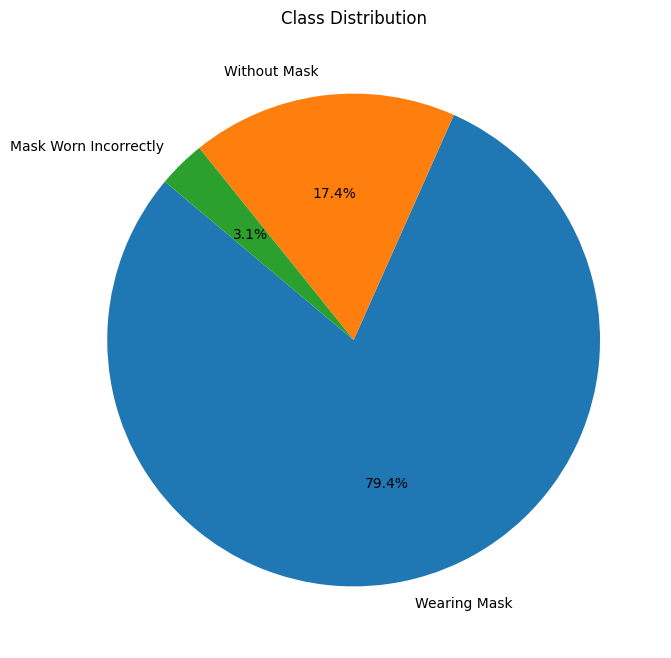

In [ ]:
''' GLOBAL dataframe with all bounding boxes are corresponding data '''

BBOXES_DF = image_annotations_to_df()
display(BBOXES_DF.head())

original_boxes_df = BBOXES_DF.copy()


print("\n")

print(f"Number of images: {BBOXES_DF['filename'].nunique()}")
print(f'Number of objects: {BBOXES_DF.shape[0]}\n')
detection_count_per_class =  BBOXES_DF.groupby('class')['xmin'].count()
print(detection_count_per_class, "\n\n")

''' VISUALIZATION OF DATA '''
# Count the occurrences of each class
class_counts = BBOXES_DF['class'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))

plt.pie(class_counts, labels = pd.Index(['Wearing Mask', 'Without Mask', 'Mask Worn Incorrectly'], dtype='object'), autopct='%1.1f%%', startangle = 140)
plt.title('Class Distribution')
plt.show()

In [ ]:
''' Give each dectection (row) a probablity of being chosen to compensate for imbalance of classes '''
weight_dict = {
         'without_mask': 1 - detection_count_per_class[2]/BBOXES_DF.shape[0],
         'mask_worn_incorrectly': 1 - detection_count_per_class[0]/BBOXES_DF.shape[0],
         'with_mask': 1 - detection_count_per_class[1]/BBOXES_DF.shape[0]
        }

BBOXES_DF['image_weight'] = BBOXES_DF['class'].replace(weight_dict)
BBOXES_DF['image_weight'] = BBOXES_DF.groupby('filename')['image_weight'].transform('mean')
display(BBOXES_DF.head())

,filename,width,height,xmin,ymin,xmax,ymax,class,bbox_area,image_weight
0,maksssksksss0.png,512,366,79,105,109,142,without_mask,1110,0.618890
1,maksssksksss0.png,512,366,185,100,226,144,with_mask,1804,0.618890
2,maksssksksss0.png,512,366,325,90,360,141,without_mask,1785,0.618890
3,maksssksksss1.png,400,156,321,34,354,69,with_mask,1155,0.274448
4,maksssksksss1.png,400,156,224,38,261,73,with_mask,1295,0.274448


In [ ]:
''' PREPARE TRAINING DATA AND VALIDATION DATA '''
data_encoder = LabelEncoder()

# Label data : 1 -> Mask Worn Incorrectly , 2 -> With Mask , 3 -> Without Mask
BBOXES_DF['label'] = data_encoder.fit_transform(BBOXES_DF['class'])
BBOXES_DF['label'] = BBOXES_DF['label'] + 1


# Categorical image type based on the weight range is for stratified splitting
# Use first 3 decimal point of 'weight' attribute to define its 'type'
BBOXES_DF['image_type'] = (BBOXES_DF['image_weight'].astype(str).apply(lambda x: x[:3]))

# Splitting by filenames and the weight range
unique_detections_df = BBOXES_DF[['filename', 'image_type']].drop_duplicates()

# Create a more balanced distribution of samples when splitting the data into training and validation sets by dropping dectections in the same images with the same or similar weights
# This is done using startify -> proportion of classes in all three data sets will be similar
train_detections, non_train_detections = train_test_split(unique_detections_df, train_size = 0.80, stratify = unique_detections_df['image_type'], random_state = 42)
validation_detections, test_detections = train_test_split(non_train_detections, train_size = 0.50, stratify = non_train_detections['image_type'], random_state = 42)


# SPLIT BALANCED DETECTION DATA INTO 3 GLOBAL DFs
TRAIN_DF = (BBOXES_DF[BBOXES_DF['filename'].isin(train_detections['filename'])].copy())

VALID_DF = (BBOXES_DF[BBOXES_DF['filename'].isin(validation_detections['filename'])].copy())

TEST_DF = (BBOXES_DF[BBOXES_DF['filename'].isin(test_detections['filename'])].copy())

# Quick Recap of Data Distributions
print('Training Dataset:')
print(f"Number of images: {TRAIN_DF['filename'].nunique()}")
print(f'Number of objects: {TRAIN_DF.shape[0]}\n')
print(TRAIN_DF.groupby('class')['xmin'].count() / len(TRAIN_DF))

print('\n------\n\nValidation Dataset:')
print(f"Number of images: {VALID_DF['filename'].nunique()}")
print(f'Number of objects: {VALID_DF.shape[0]}\n')
print(VALID_DF.groupby('class')['xmin'].count() / len(VALID_DF))

print('\n------\n\nTesting Dataset:')
print(f"Number of images: {TEST_DF['filename'].nunique()}")
print(f'Number of objects: {TEST_DF.shape[0]}\n')
print(TEST_DF.groupby('class')['xmin'].count() / len(TEST_DF))

Training Dataset:
Number of images: 682
Number of objects: 3089

class
mask_worn_incorrectly    0.030431
with_mask                0.794432
without_mask             0.175138
Name: xmin, dtype: float64

------

Validation Dataset:
Number of images: 85
Number of objects: 487

class
mask_worn_incorrectly    0.032854
with_mask                0.786448
without_mask             0.180698
Name: xmin, dtype: float64

------

Testing Dataset:
Number of images: 86
Number of objects: 345

class
mask_worn_incorrectly    0.034783
with_mask                0.805797
without_mask             0.159420
Name: xmin, dtype: float64


In [ ]:
''' Augmentation of Images to further diversify dataset '''

training_transforms = A.Compose([
                        A.OneOf([
                            A.ColorJitter(hue = 0.1),
                            A.Equalize(by_channels=False),
                            A.FancyPCA(),
                            A.GaussNoise(),
                            A.ImageCompression(),
                            A.ISONoise(),
                            A.RandomGamma(),
                            A.RandomToneCurve(),
                            A.RGBShift(r_shift_limit  = 15, g_shift_limit = 15, b_shift_limit = 15),
                            A.AdvancedBlur(p = 0.1)]),
                          ToTensorV2()],
                          bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['labels'], min_area = 51)
                      )

valid_transforms = ToTensorV2()
test_transforms = ToTensorV2()

In [ ]:
''' Prepare Dataset Loader for model training '''

class imageRepository(Dataset):

    def __init__(self, df, image_dir, transforms):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_names = df["filename"].unique()


    def __getitem__(self, index):
        ''' Load image '''

        # Retrieve image
        image_filename = self.image_names[index]
        image_path = self.image_dir + "/" + image_filename

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Perform Augmentation
        mask = self.df['filename'] == image_filename

        image_height = self.df[mask]['height'].iloc[0]
        image_width = self.df[mask]['width'].iloc[0]

        bounding_boxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        #bounding_boxes = normalize_bbox(bounding_boxes, image_height, image_width)

        labels = np.array((self.df[mask]['label']))

        # Get Transformed image along with augmented corresponding bounding boxes
        transformed_data = self.transforms(image = image, bboxes = bounding_boxes, labels = labels)
        aug_image = transformed_data['image']

        bounding_boxes = torch.as_tensor(transformed_data['bboxes'], dtype = torch.float32)
        labels = torch.as_tensor(labels, dtype = torch.int64)

        # Create Dict w/ true labels and gt data
        image_Targets = {}
        image_Targets["boxes"] = bounding_boxes
        image_Targets["labels"] = labels

        final_image = aug_image / 255

        return final_image, image_Targets



    def __len__(self):
        return len(self.image_names)



def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
"""Check dataset loading and transformation
"""
train_dataset = imageRepository(TRAIN_DF, IMAGE_PATH, training_transforms)
valid_dataset = imageRepository(VALID_DF, IMAGE_PATH, valid_transforms)
test_dataset = imageRepository(TEST_DF, IMAGE_PATH, test_transforms)

In [ ]:
''' Prepare Data Loader '''

# Weights each unique image (not to be  confused w/ model NN weights)
# These tensors represent the 'weight' of each image which is computed using the weights of individual detections that correspond to that image
train_image_weights = torch.as_tensor(np.array(TRAIN_DF.drop_duplicates(subset='filename')['image_weight']), dtype=torch.float16)
valid_image_weights = torch.as_tensor(np.array(VALID_DF.drop_duplicates(subset='filename')['image_weight']), dtype=torch.float16)

# Use Weighted Random Sampler so that minor classes (classes w less instances) have higher likelihood of being presented to the model
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_image_weights, len(train_image_weights))
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(valid_image_weights, len(valid_image_weights))


# Instantiate Data loaders
TRAIN_DATALOADER = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 5,
    sampler = train_sampler,
    num_workers = 5,
    collate_fn = collate_fn
)

VALID_DATALOADER = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size = 5,
    sampler = valid_sampler,
    num_workers = 5,
    collate_fn = collate_fn
)

TEST_DATALOADER = torch.utils.data.DataLoader(
    test_dataset,
    batch_size =  5,
    num_workers = 5,
    collate_fn = collate_fn
)

In [ ]:
''' Model Class '''

class FaceMaskDetector(object):

    device = None
    model = None
    train_mode = False


    def __init__(self, model_version, learning_rate):
        self.model_version = model_version
        self.learning_rate = learning_rate


    # Set mode of model
    def set_to_training(self):
      self.train_mode = True
      self.model.train()


    def set_to_testing(self):
      self.train_mode = False
      self.model.eval()



    ''' Prepare data for training '''
    def load_model(self):

        # Set device to run computations on GPU
        self.device = torch.device('cuda')

        class_count = 4 # background, with mask, without mask, and mask worn incorrectly

        # Instantiate model based on resnet50 backbone and pretrained weights if Faster RCNN
        if self.model_version == "Faster_RCNN":

            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

            # Adapt model by adding a new fully connected layer that takes the input features from the ROI pooling layer (1024 features) and produces scores for 4 classes
            input_features = self.model.roi_heads.box_predictor.cls_score.in_features

            self.model.roi_heads.box_predictor = FastRCNNPredictor(input_features, class_count)


        # 'Move' our model to this laptops CPU
        self.model = self.model.to(self.device)

        # Set parameters and optimizers
        parameters = [p for p in self.model.parameters() if p.requires_grad]

        optimizer = torch.optim.SGD(parameters, lr = self.learning_rate, momentum = 0.9)

        return optimizer




    ''' Train model '''
    def train(self, optimizer, mask_data_loader):

        print("Training Started ...\n")

        # Set model to train mode
        if self.train_mode == False:
          self.set_to_training()

        torch.set_grad_enabled(True)

        class_loss_list = []
        box_loss_list = []

        # Train in batches of size 5
        for images, targets in mask_data_loader:

            # Image batch
            images = list(image.to(self.device) for image in images)

            # Corresponding values for bbox, label, & more
            targets = [ { K : V.to(self.device) for K, V in target.items() } for target in targets ]

            # Forward Propogation -> Retrieve loss / error
            loss_dict = self.model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Add to this epochs list of total loss -> avg
            classification_loss = loss_dict['loss_classifier'].item()
            regression_box_loss = loss_dict['loss_box_reg'].item()

            class_loss_list.append(classification_loss)
            box_loss_list.append(regression_box_loss)

            # Update optimizer and learning rate
            optimizer.zero_grad()
            losses.backward()  # Backpropagation: compute gradients
            optimizer.step()   # Update model parameters based on gradients

        print("Done w an epoch")

        return np.mean(class_loss_list), np.mean(box_loss_list)




    ''' Evaluate model during training '''
    def validate(self, mask_data_loader):

        print("\nEvaluation Started ...\n")

        if self.train_mode == False:
          self.set_to_training()

        # Do not allow gradient descent to adjust weights
        class_loss_list = []
        box_loss_list = []

        # Train in batches of size 5
        with torch.no_grad():

          for images, targets in mask_data_loader:

              # Image batch
              images = list(image.to(self.device) for image in images)

              # Corresponding values for bbox, label, & more
              targets = [ { K : V.to(self.device) for K, V in target.items() } for target in targets ]

              # Forward Propogation -> Retrieve loss / error
              loss_dict = self.model(images, targets)

              # Add to this epochs list of total loss -> avg
              classification_loss = loss_dict['loss_classifier'].item()
              regression_box_loss = loss_dict['loss_box_reg'].item()

              class_loss_list.append(classification_loss)
              box_loss_list.append(regression_box_loss)


        print("Done w an epoch")

        return np.mean(class_loss_list), np.mean(box_loss_list)





    ''' Test Model after Training and Optimal Params '''
    def calculate_mAP(self, mask_data_loader):

      # Computes the mean average precision over a dataset

      # Set model to evaluation mode
      self.set_to_testing()

      prediction_list = []
      ground_truth_list = []

      with torch.no_grad():

        for images, targets in mask_data_loader:

          # Image batch
          images = list(image.to(self.device) for image in images)

          # Corresponding values for bbox, label, & more
          targets = [ { K : V.to(self.device) for K, V in target.items() } for target in targets ]

          # Forward pass to get predictions
          predictions = self.model(images)

          # Append the target class and target bbox
          ground_truth_list.extend(targets)

          # Filter only high confidence predictions
          high_confidence_predictions = list(self.drop_low_confidence(prediction) for prediction in predictions)
          final_predictions = list(self.apply_nms(prediction) for prediction in high_confidence_predictions)

          # Extend the prediction list
          prediction_list.extend(final_predictions)

        mAP = MeanAveragePrecision(class_metrics = True)
        mAP.update(prediction_list, ground_truth_list)

        return mAP.compute()




    ''' Visualize the models predictions '''
    def plot_prediction(self, image_filename):

      image = Image.open(IMAGE_PATH + "/" + image_filename).convert('RGB')
      image_tensor = transforms.ToTensor()(image).unsqueeze(0).to('cuda')

      # Set model to evaluation mode
      if self.train_mode == True:
        self.set_to_testing()

      with torch.no_grad():

          prediction = self.model(image_tensor)

          # Get data
          targets = original_boxes_df[original_boxes_df["filename"] == image_filename]

          gt_bboxes = []
          gt_labels = []

          for index, row in targets.iterrows():
              xmin, xmax, ymin, ymax = row["xmin"], row["xmax"], row["ymin"], row["ymax"]
              label = row["class"]
              gt_bboxes.append((xmin, ymin, xmax, ymax))
              gt_labels.append(label)

          # Extracting bboxes, confidence scores, and labels
          high_confidence_predictions = self.drop_low_confidence(prediction[0])
          final_predictions = self.apply_nms(high_confidence_predictions)
          predicted_bboxes = final_predictions['boxes'].cpu().numpy()
          predicted_labels = final_predictions['labels'].cpu().numpy()

          # Plot predictions and ground truth on the same image
          image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
          image_np = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

          thickness = 1

          # Overlay predicted bounding boxes
          for box, label in zip(predicted_bboxes, predicted_labels):
              box = [int(x) for x in box]
              if label == 2:
                color = (0, 225, 0)
                cv2.putText(image_np, "Predicted (G)", (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
              else:
                color = (0, 0, 225)
                cv2.putText(image_np, "Predicted (R)", (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

              cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, thickness)

          # Overlay ground truth bounding boxes
          for box, _class in zip(gt_bboxes, gt_labels):
              box = [int(x) for x in box]
              if _class == "with_mask":
                color = (255, 0, 0)
                cv2.putText(image_np, "Ground Truth (B)", (box[0], box[3] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
              else:
                color = (255, 255, 225)
                cv2.putText(image_np, "Ground Truth (W)", (box[0], box[3] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

              cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, thickness)


          image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

          # Display the image with overlaid bounding boxes
          plt.figure(figsize=(10, 10))
          plt.imshow(image_np)
          plt.axis('off')
          plt.show()






    ''' ------------- HELPER & UTILITY FUNCTIONS ------------- '''

    def apply_nms(self, base_prediction, iou_threshold = 0.7):
      # Non-maximum supression: deleting lower-confidence bboxes overlapped with iou > intersection over union threshold
      keep = torchvision.ops.nms(base_prediction['boxes'], base_prediction['scores'], iou_threshold)
      final_prediction = base_prediction
      final_prediction['boxes'] = final_prediction['boxes'][keep]
      final_prediction['scores'] = final_prediction['scores'][keep]
      final_prediction['labels'] = final_prediction['labels'][keep]
      return final_prediction


    def drop_low_confidence(self, base_prediction, confidence_threshold = 0.35):
      # Dropping bboxes with low confidence scores
      keep = []

      for idx, confidence in enumerate(base_prediction['scores']):
          if confidence > confidence_threshold:
              keep.append(idx)

      high_conf_preds = base_prediction
      high_conf_preds['boxes'] = high_conf_preds['boxes'][keep]
      high_conf_preds['scores'] = high_conf_preds['scores'][keep]
      high_conf_preds['labels'] = high_conf_preds['labels'][keep]

      return high_conf_preds


In [ ]:
''' Evaluating Faster-RCNN model for optimal epoch '''

def train_and_evaluate():

    max_epoch = 40

    train_class_losses = []
    train_box_losses = []

    validate_class_losses = []
    validate_box_losses = []

    # Instantiate model
    Faster_RCNN_Mask_Detector = FaceMaskDetector(model_version = "Faster_RCNN", learning_rate = 0.01)

    # Load model and get optimizer
    optimizer = Faster_RCNN_Mask_Detector.load_model()

    # Train model for n epochs, gathering the loss function for the train and validation dataset
    for epoch in range(max_epoch):

      print("\n----------------------------\nEpoch era ->", epoch + 1)

      train_class_loss, train_box_loss = Faster_RCNN_Mask_Detector.train(optimizer, TRAIN_DATALOADER)

      train_class_losses.append(train_class_loss)
      train_box_losses.append(train_box_loss)

      print("Train class loss for epoch ", epoch + 1, "is", train_class_loss)
      print("Train bbox reg loss for epoch ", epoch + 1, "is", train_box_loss, "\n")

      valid_class_loss, valid_box_loss = Faster_RCNN_Mask_Detector.validate(VALID_DATALOADER)

      validate_class_losses.append(valid_class_loss)
      validate_box_losses.append(valid_box_loss)

      print("Validation class loss for epoch ", epoch + 1, "is ", valid_class_loss)
      print("Validation bbox reg loss for epoch ", epoch + 1, "is ", valid_box_loss, "\n")
      print("\n\n")


    print(train_class_losses)
    print(train_box_losses)
    print(validate_class_losses)
    print(validate_box_losses)

    print(Faster_RCNN_Mask_Detector.calculate_mAP(TEST_DATALOADER))

    print("\n\n")

    epoch_list = range(max_epoch)

    style.use('seaborn')

    # Plotting
    plt.figure(figsize = (10, 10))

    # Class loss plots
    plt.subplot(2, 1, 1)
    plt.plot(epoch_list, train_class_losses, label='Training Dataset Classification Loss', color = "green")
    plt.plot(epoch_list, validate_class_losses, label='Validation Dataset Classification Loss', color = "red")
    plt.title('Faster R-CNN ResNet50 Classification Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Reg box loss plots
    plt.subplot(2, 1, 2)
    plt.plot(epoch_list, train_box_losses, label='Training Dataset Bounding Box Loss', color = "green")
    plt.plot(epoch_list, validate_box_losses, label='Validation Dataset Bounding Box Loss', color = "red")
    plt.title('Faster R-CNN ResNet50 Bounding Box Regression Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

train_and_evaluate()

In [ ]:
''' EVALUATION : Computing the mAP for Faster_RCNN optimal parameters on Testing dataset (separate from train and validation datasets) '''

def Compute_mAP():

  # Instantiate
  Opt_Faster_RCNN_Mask_Detector = FaceMaskDetector(model_version = 'Faster_RCNN', learning_rate = 0.01)

  # Load Model
  optimizer = Opt_Faster_RCNN_Mask_Detector.load_model()

  # Optimal epoch count
  opt_epoch_count = 25

  # Train Model
  for epoch in range(opt_epoch_count):
    Opt_Faster_RCNN_Mask_Detector.train(optimizer, TRAIN_DATALOADER)

  # Predict on testing dataset and compute mAP
  return Opt_Faster_RCNN_Mask_Detector.calculate_mAP(TEST_DATALOADER)


print(Compute_mAP())


Bounding Box plot after training for 1 epoch(s)

Training Started ...

Done w an epoch


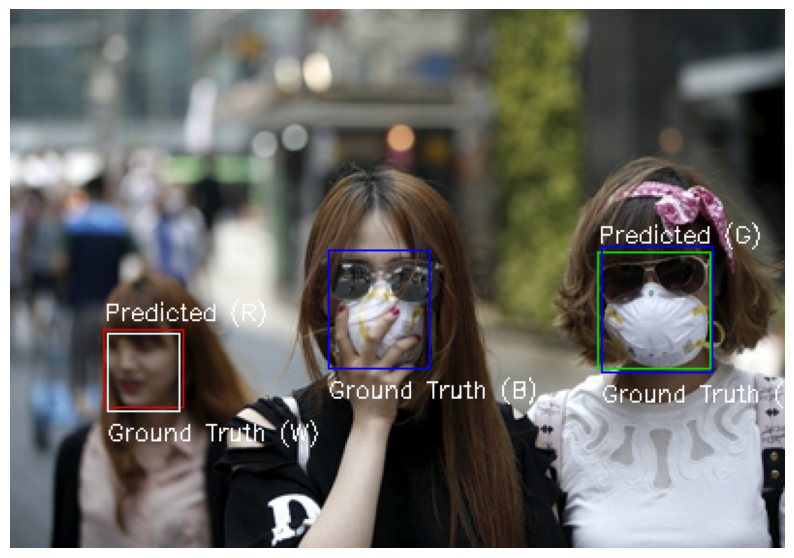

Bounding Box plot after training for 2 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 3 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 4 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 5 epoch(s)

Training Started ...

Done w an epoch


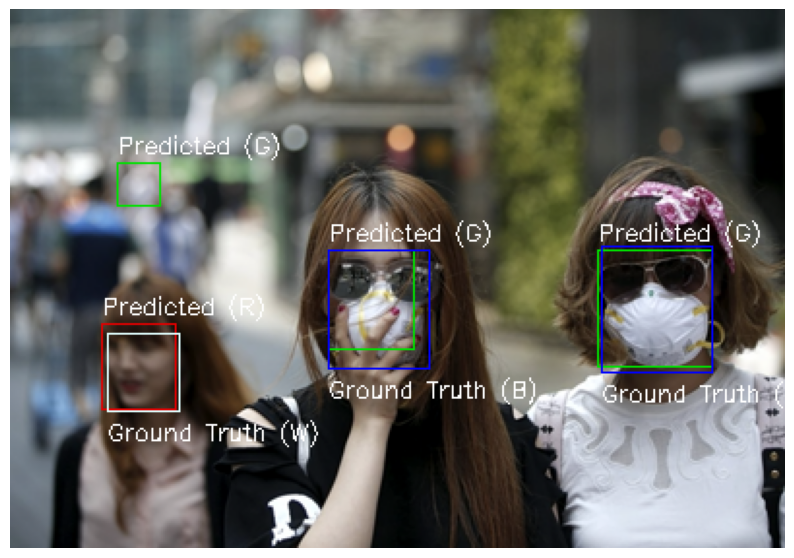

Bounding Box plot after training for 6 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 7 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 8 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 9 epoch(s)

Training Started ...

Done w an epoch
Bounding Box plot after training for 10 epoch(s)

Training Started ...

Done w an epoch


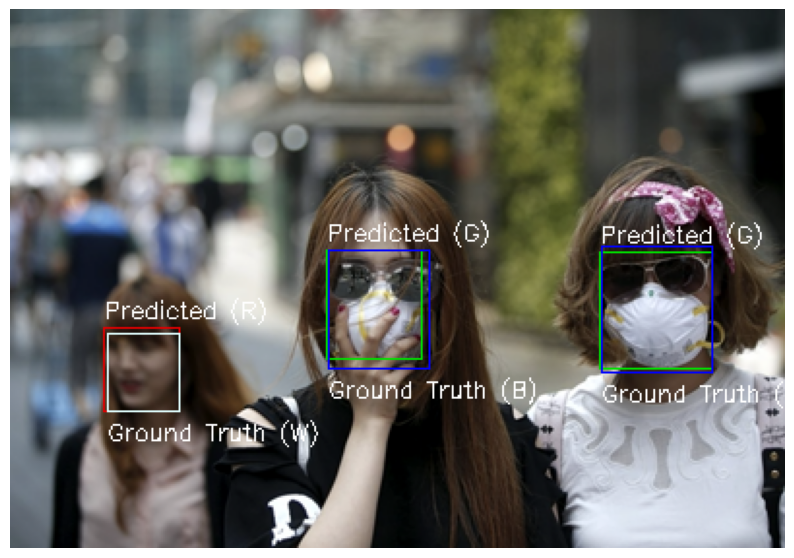

In [ ]:
''' Display Predicted Bounding Boxs Over Epoch '''
def display_predicted_bounding_boxes():

  # Instantiate model
  Faster_RCNN_Mask_Detector = FaceMaskDetector(model_version = "Faster_RCNN", learning_rate = 0.01)

  # Load model and get optimizer
  optimizer = Faster_RCNN_Mask_Detector.load_model()

  epochs = 10

  sample_img_filename = "maksssksksss263.png"

  for epoch in range(epochs):

    print("Bounding Box plot after training for", epoch + 1, "epoch(s)\n")

    # Switches model to train mode -> True
    Faster_RCNN_Mask_Detector.train(optimizer, TRAIN_DATALOADER)

    # Switches model to eval mode (train mode -> False)
    if epoch + 1 == 1 or epoch + 1 == 5 or epoch + 1 == 10:
      Faster_RCNN_Mask_Detector.plot_prediction(sample_img_filename)


display_predicted_bounding_boxes()

YOLOv8 Medium Model setup, training, and validation done below.

In [ ]:
''' Setting up Directories for YOLO training and validation '''

def prepare_dataset_for_yolo(df, is_training_set, is_validation_set):
  ''' For the YOLO model we must create special annotations for the images and saving these to train/validation folders '''

  # YOLO bboxes must have x-center, y-center, the height, and width
  df["x-center"] = (df["xmin"] + df["xmax"]) / 2 / df["width"]
  df["y-center"] = (df["ymin"] + df["ymax"]) / 2 / df["height"]

  df["bbox-width"] = (df["xmax"] - df["xmin"]) / df["width"]
  df["bbox-height"] = (df["ymax"] - df["ymin"]) / df["height"]


  for image in tqdm(df["filename"].unique()):

    if is_training_set:
      yolo_image_folder = YOLO_PATH + "/" + "train/images"
      yolo_label_folder = YOLO_PATH + "/" + "train/labels"

    elif is_validation_set:
      yolo_image_folder = YOLO_PATH + "/" + "valid/images"
      yolo_label_folder = YOLO_PATH + "/" + "valid/labels"

    else:
      yolo_image_folder = YOLO_PATH + "/" + "test/images"
      yolo_label_folder = YOLO_PATH + "/" + "test/labels"


    # Copy images from parent images folder IMAGE_PATH
    shutil.copy(IMAGE_PATH + "/" + image, yolo_image_folder)

    # Cretae a YOLO .txt file for each image with bounding box params
    image_data = df[df["filename"] == image]

    yolo_image_data = (image_data[["label", "x-center", "y-center", "bbox-width", "bbox-height"]])

    text_filename = yolo_label_folder + "/" + image.replace(".png", ".txt")

    yolo_image_data.to_csv(text_filename, sep = " ", header = False, index = False)


In [ ]:
''' Prepare YOLO folders and Adjust Classes (RUN ONLY ONCE)'''

# In YOLO, labels of the classes must begin from 0
#TRAIN_DF["label"] = TRAIN_DF["label"] - 1
#VALID_DF["label"] = VALID_DF["label"] - 1
#TEST_DF["label"] = TEST_DF["label"] - 1
#
#
## Create directories with text files
#Path(YOLO_PATH + "/" + 'train/images').mkdir(parents=True, exist_ok=True)
#Path(YOLO_PATH + "/" + 'train/labels').mkdir(parents=True, exist_ok=True)
#Path(YOLO_PATH + "/" + 'valid/images').mkdir(parents=True, exist_ok=True)
#Path(YOLO_PATH + "/" + 'valid/labels').mkdir(parents=True, exist_ok=True)
#Path(YOLO_PATH + "/" + 'test/images').mkdir(parents=True, exist_ok=True)
#Path(YOLO_PATH + "/" + 'test/labels').mkdir(parents=True, exist_ok=True)
#
#prepare_dataset_for_yolo(TRAIN_DF, is_training_set = True, is_validation_set = False)
#prepare_dataset_for_yolo(VALID_DF, is_training_set = False, is_validation_set = True)
#prepare_dataset_for_yolo(TEST_DF, is_training_set = False, is_validation_set = False)
#
#
''' Write a Configuration File '''

text = """
names:
  0: mask_worn_incorrectly
  1: mask
  2: no_mask
"""

train_imgs = YOLO_PATH + "/" + 'train/images'
valid_imgs = YOLO_PATH + "/" + 'valid/images'
test_imgs = YOLO_PATH + "/" + 'test/images'


with open("mask_detection.yaml", 'w') as f:
  f.write(f"train: {train_imgs}\n")
  f.write(f"val: {valid_imgs}\n")
  f.write(f"test: {test_imgs}\n")
  f.write(text)

100%|██████████| 86/86 [00:07<00:00, 10.94it/s]


In [ ]:
''' YOLOv8 Model Custom Class '''

class YOLOFaceMaskDetector(object):

    model = None

    def __init__(self, max_epoch):
        self.max_epoch = max_epoch

        # start a new wandb run to track this script
        wandb.init(
            # set the wandb project where this run will be logged
            project = "faceMaskDetection",

            # track hyperparameters and run metadata
            config = {
            "learning_rate": 0.0143,
            "architecture": "YOLO",
            "dataset": "Custom Kaggle Dataset",
            "epochs": max_epoch,
            }
        )



    def load_model(self, get_metrics):
      # Loading a pretrained model
      self.model = YOLO('yolov8m.pt')

      self.device = torch.device('cuda')

      # 'Move' our model to this laptops CPU
      self.model = self.model.to(self.device)



    ''' Train Model '''
    def train(self):
      self.model.train(data = 'mask_detection.yaml', batch = 5, epochs = self.max_epoch, workers = 5)
      wandb.finish()



    ''' Visualize YOLO's predictions '''
    def plot_prediction(self, image_filename):

      image_path = IMAGE_PATH + "/" + image_filename
      image_np = cv2.imread(image_path)
      image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
      image_tensor = transforms.ToTensor()(image_np).unsqueeze(0).to('cuda')

      with torch.no_grad():

          prediction = self.model.predict(image_path, conf = 0.7, iou = 0.3, show = True)

          # Get ground truth data
          targets = original_boxes_df[original_boxes_df["filename"] == image_filename]

          gt_bboxes = []
          gt_labels = []

          for index, row in targets.iterrows():
              xmin, xmax, ymin, ymax = row["xmin"], row["xmax"], row["ymin"], row["ymax"]
              label = row["class"]
              gt_bboxes.append((xmin, ymin, xmax, ymax))
              gt_labels.append(label)


          # Extracting bboxes, confidence scores, and labels
          predicted_bboxes = prediction[0].boxes.xyxy.to('cpu')
          predicted_labels = prediction[0].boxes.cls.to('cpu').numpy()

          # Plot predictions and ground truth on the same image
          image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
          image_np = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

          thickness = 1

          # Overlay predicted bounding boxes
          for box, label in zip(predicted_bboxes, predicted_labels):
              box = [int(x) for x in box]
              if label == 1:
                color = (0, 225, 0)
                cv2.putText(image_np, "Predicted (G)", (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
              else:
                color = (0, 0, 225)
                cv2.putText(image_np, "Predicted (R)", (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

              cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, thickness)

          # Overlay ground truth bounding boxes
          for box, _class in zip(gt_bboxes, gt_labels):
              box = [int(x) for x in box]
              if _class == "with_mask":
                color = (255, 0, 0)
                cv2.putText(image_np, "Ground Truth (B)", (box[0], box[3] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
              else:
                color = (255, 255, 225)
                cv2.putText(image_np, "Ground Truth (W)", (box[0], box[3] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

              cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, thickness)


          image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

          # Display the image with overlaid bounding boxes
          plt.figure(figsize=(10, 10))
          plt.imshow(image_np)
          plt.axis('off')
          plt.show()





    ''' On Testing Dataset '''
    def calculate_mAP(self, df, image_filename):
      # Computes the mean average precision over a dataset

      prediction_list = []
      ground_truth_list = []

      # Corresponding values for bbox, label, & more
      targets = df[df["filename"] == image_filename]

      ground_truths = {}

      ground_truths["boxes"] = []
      ground_truths["labels"] = []

      for index, row in targets.iterrows():
          if row["label"] < 0:
            print("issue")

          xmin, xmax, ymin, ymax = row["xmin"], row["xmax"], row["ymin"], row["ymax"]
          ground_truths["boxes"].append([xmin, ymin, xmax, ymax])
          ground_truths["labels"].append(row["label"] - 1)

      ground_truths["boxes"] =  torch.tensor(ground_truths["boxes"], device = self.device)
      ground_truths["labels"] =  torch.tensor(ground_truths["labels"], device = self.device)


      image_path = IMAGE_PATH + "/" + image_filename

      # Forward pass to get predictions
      final_prediction = self.model.predict(image_path, conf = 0.7, iou = 0.3, show = False)

      # Create list of dicts for predictions
      predictions = {}

      predictions["boxes"] = final_prediction[0].boxes.xyxy
      predictions["labels"] = final_prediction[0].boxes.cls.int()
      predictions["scores"] = final_prediction[0].boxes.conf

      return [predictions], [ground_truths]



In [ ]:
''' Train Yolo Model '''

# Instantiate model
YOLO_Mask_Detector = YOLOFaceMaskDetector(max_epoch = 100)

# Load model
YOLO_Mask_Detector.load_model(get_metrics = True)

# Train model
YOLO_Mask_Detector.train()

In [ ]:
''' Compute mAP on Optimally Trained YOLO Model via TEST dataset'''
def compute_mAP(opt_epoch):

  YOLO_Mask_Detector = YOLOFaceMaskDetector(max_epoch = opt_epoch)

  # Load model
  YOLO_Mask_Detector.load_model(get_metrics = True)

  # Train model
  YOLO_Mask_Detector.train()

  ground_truth_list = []
  prediction_list = []

  for filename in VALID_DF["filename"].unique():
      preds, gts = YOLO_Mask_Detector.calculate_mAP(VALID_DF, filename)
      ground_truth_list.extend(gts)
      prediction_list.extend(preds)

  mAP = MeanAveragePrecision(class_metrics = True)
  mAP.update(prediction_list, ground_truth_list)
  return mAP.compute()


print(compute_mAP(opt_epoch = 70))


SHOW PREDICTED BOUNDING BOXES OVER TRAINING EPOCHS FOR YOLO (1, 5, 10 Epochs)

Bounding Box plot after training YOLO model for 1 epoch(s)



engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=mask_detection.yaml, epochs=1, patience=50, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=5, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, wor

100%|██████████| 755k/755k [00:00<00:00, 44.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 174MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/YoloV8/train/labels... 681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 681/681 [00:58<00:00, 11.65it/s]


train: New cache created: /content/drive/MyDrive/YoloV8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/YoloV8/valid/labels... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:22<00:00,  7.69it/s]

val: New cache created: /content/drive/MyDrive/YoloV8/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005078125), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 5 dataloader workers
Logging results to runs/detect/train2
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.84G      1.441      1.595      1.289          3        640: 100%|██████████| 137/137 [00:17<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        172        745      0.819      0.536      0.581      0.374

1 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.85it/s]


                   all        172        745      0.819      0.536      0.581      0.374
 mask_worn_incorrectly        172         18      0.875     0.0556      0.115     0.0864
                  mask        172        578      0.875       0.86      0.915      0.598
               no_mask        172        149      0.706      0.691      0.713      0.437
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/mAP50(B),▁
metrics/mAP50-95(B),▁
metrics/precision(B),▁
metrics/recall(B),▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▁


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/images/maksssksksss263.png: 448x640 1 mask, 70.6ms
Speed: 1.9ms preprocess, 70.6ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


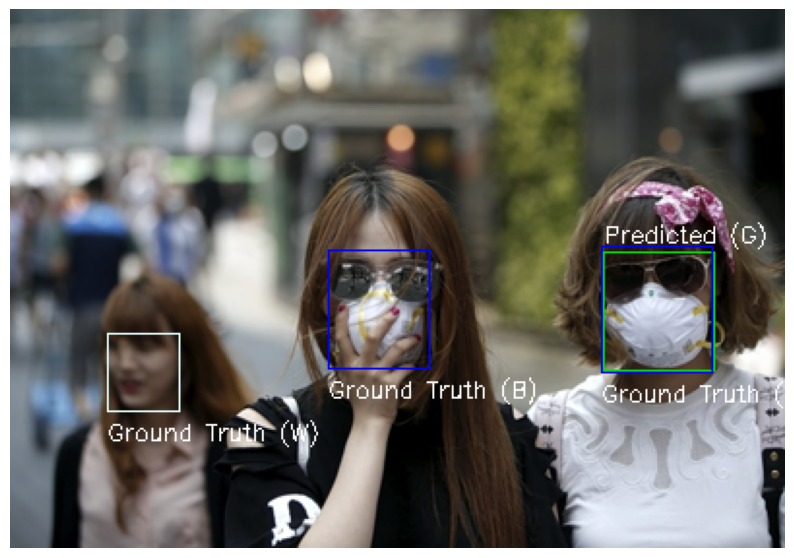

In [ ]:
''' Show predicted bounding boxes after training for 1 epochs (YOLO) '''

SAMPLE_IMG_FILENAME = "maksssksksss263.png"

# Plot the progression of box predictions
epoch = 1

print("Bounding Box plot after training YOLO model for", epoch, "epoch(s)\n")

# Instantiate model
YOLO_Mask_Detector = YOLOFaceMaskDetector(max_epoch = epoch)

# Load model
YOLO_Mask_Detector.load_model(get_metrics = False)

# Train model
YOLO_Mask_Detector.train()

# Show prediction
YOLO_Mask_Detector.plot_prediction(SAMPLE_IMG_FILENAME)


wandb: Currently logged in as: georgepm20002 (g4). Use `wandb login --relogin` to force relogin


Bounding Box plot after training YOLO model for 5 epoch(s)



engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=mask_detection.yaml, epochs=5, patience=50, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=5, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, wor

train: Scanning /content/drive/MyDrive/YoloV8/train/labels.cache... 681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 681/681 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/YoloV8/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005078125), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 5 dataloader workers
Logging results to runs/detect/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.94G      1.441      1.595      1.289          3        640: 100%|██████████| 137/137 [00:16<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:44<00:00,  2.49s/it]


                   all        172        745      0.819      0.536      0.581      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.01G      1.258     0.9688      1.136          5        640: 100%|██████████| 137/137 [00:14<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.16it/s]

                   all        172        745      0.841      0.551      0.632      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.92G      1.169     0.8533      1.123         14        640: 100%|██████████| 137/137 [00:14<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.23it/s]

                   all        172        745      0.651      0.638      0.652      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.91G      1.144     0.7865      1.124          2        640: 100%|██████████| 137/137 [00:14<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.14it/s]

                   all        172        745      0.718      0.695       0.73      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.91G      1.168     0.7863      1.127          7        640: 100%|██████████| 137/137 [00:14<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.99it/s]

                   all        172        745      0.842       0.66      0.731      0.501



5 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


                   all        172        745      0.841       0.66      0.732      0.501
 mask_worn_incorrectly        172         18      0.754      0.278      0.368      0.274
                  mask        172        578      0.883      0.929      0.951       0.67
               no_mask        172        149      0.887      0.772      0.876      0.558
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


lr/pg0,▁▆█▃▃
lr/pg1,▁▆█▃▃
lr/pg2,▁▆█▃▃
metrics/mAP50(B),▁▃▄██
metrics/mAP50-95(B),▁▃▄▇█
metrics/precision(B),▇█▁▃█
metrics/recall(B),▁▂▅█▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▂▁▂


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/images/maksssksksss263.png: 448x640 2 masks, 1 no_mask, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


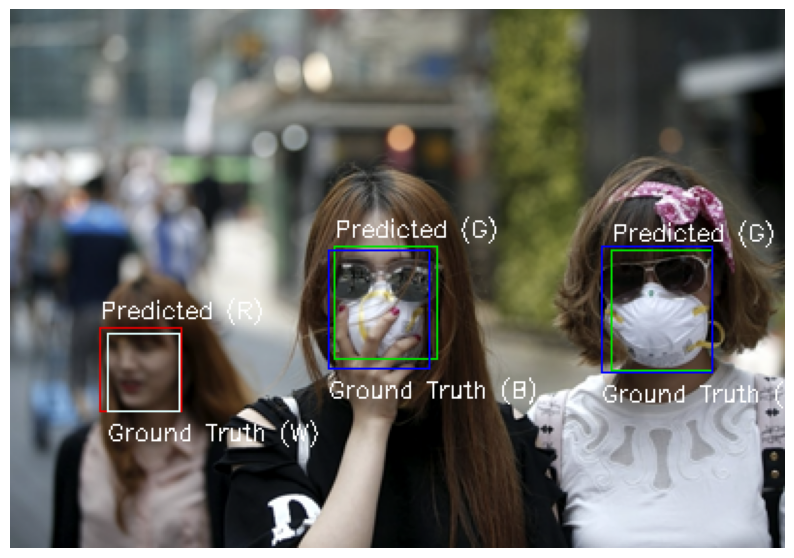

In [ ]:
''' Show predicted bounding boxes after training for 5 epochs (YOLO) '''

# Plot the progression of box predictions
epoch = 5

print("Bounding Box plot after training YOLO model for", epoch, "epoch(s)\n")

# Instantiate model
YOLO_Mask_Detector = YOLOFaceMaskDetector(max_epoch = epoch)

# Load model
YOLO_Mask_Detector.load_model(get_metrics = False)

# Train model
YOLO_Mask_Detector.train()

# Show prediction
YOLO_Mask_Detector.plot_prediction(SAMPLE_IMG_FILENAME)

Bounding Box plot after training YOLO model for 10 epoch(s)



engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=mask_detection.yaml, epochs=10, patience=50, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=5, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, wo

train: Scanning /content/drive/MyDrive/YoloV8/train/labels.cache... 681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 681/681 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/YoloV8/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005078125), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 5 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.67G      1.538       2.11      1.375          3        640: 100%|██████████| 137/137 [00:17<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.21it/s]

                   all        172        745      0.867      0.398      0.485      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.66G      1.281      1.166      1.236          7        640: 100%|██████████| 137/137 [00:15<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.33it/s]

                   all        172        745      0.888      0.451      0.531      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       3.6G      1.291      1.132      1.258          6        640: 100%|██████████| 137/137 [00:15<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.69it/s]

                   all        172        745      0.656      0.541       0.57      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       3.7G      1.263     0.9774      1.216          5        640: 100%|██████████| 137/137 [00:14<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.40it/s]

                   all        172        745      0.838      0.565      0.617      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.58G       1.32      1.087      1.265          1        640: 100%|██████████| 137/137 [00:14<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.38it/s]

                   all        172        745      0.586      0.547      0.588      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.57G      1.216     0.8852      1.187          6        640: 100%|██████████| 137/137 [00:14<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.28it/s]

                   all        172        745      0.731      0.635      0.694      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.57G      1.167      0.787      1.183          6        640: 100%|██████████| 137/137 [00:14<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.30it/s]

                   all        172        745      0.726      0.641      0.679      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.55G      1.155     0.7624      1.153          5        640: 100%|██████████| 137/137 [00:14<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 11.50it/s]

                   all        172        745      0.713      0.693       0.72      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.57G       1.11     0.7004       1.12          3        640: 100%|██████████| 137/137 [00:14<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.70it/s]

                   all        172        745      0.752      0.672      0.751      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.56G       1.06     0.6335      1.099          1        640: 100%|██████████| 137/137 [00:14<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.71it/s]

                   all        172        745      0.891      0.655      0.791      0.546



10 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 52.0MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


                   all        172        745      0.848      0.684      0.793      0.548
 mask_worn_incorrectly        172         18      0.682      0.389      0.547      0.401
                  mask        172        578      0.944      0.891      0.961      0.693
               no_mask        172        149      0.918      0.772       0.87      0.549
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train5


lr/pg0,▂▆█▇▇▆▅▃▂▁
lr/pg1,▂▆█▇▇▆▅▃▂▁
lr/pg2,▂▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▂▃▄▃▆▅▆▇█
metrics/mAP50-95(B),▁▂▃▄▃▅▅▆▇█
metrics/precision(B),▇█▃▇▁▄▄▄▅▇
metrics/recall(B),▁▂▄▅▅▇▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▄▄▅▃▃▂▂▁


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/images/maksssksksss263.png: 448x640 2 masks, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


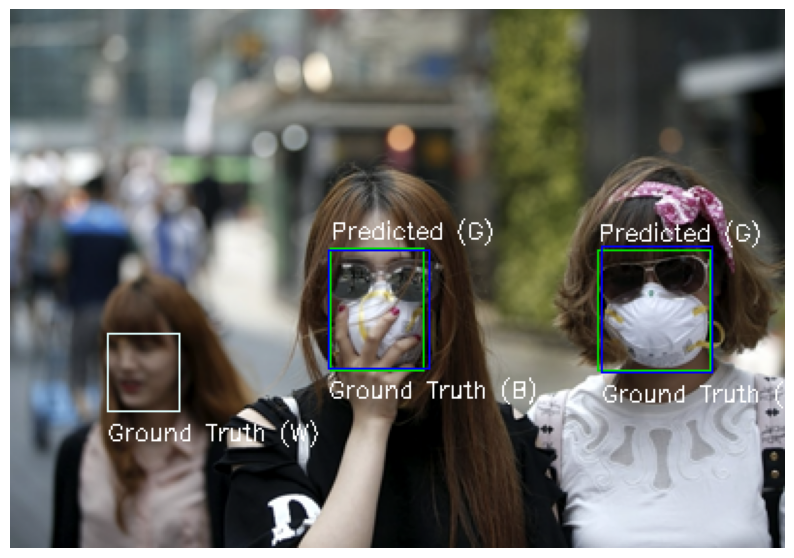

In [ ]:
''' Show predicted bounding boxes after training for 10 epochs (YOLO) '''

# Plot the progression of box prediction
SAMPLE_IMG_FILENAME = "maksssksksss263.png"

epoch = 10

print("Bounding Box plot after training YOLO model for", epoch, "epoch(s)\n")

# Instantiate model
YOLO_Mask_Detector = YOLOFaceMaskDetector(max_epoch = epoch)

# Load model
YOLO_Mask_Detector.load_model(get_metrics = False)

# Train model
YOLO_Mask_Detector.train()

# Show prediction
YOLO_Mask_Detector.plot_prediction(SAMPLE_IMG_FILENAME)